# **Introduction**

This is my first Kaggle, and my first foray into data analysis using python.  The following kernel contains the steps enumerated below for assessing the Titanic survival dataset:

1. Import data and python packages
2. Assess Data Quality & Missing Values
    * 2.1 Age - Missing Values
    * 2.2 Cabin - Missing Values
    * 2.3 Embarked - Missing Values
    * 2.4 Final Adjustments to Data
    * 2.4.1 Additional Variables
3. Exploratory Data Analysis
4. Logistic Regression 
5. Hold-Out Testing & Model Assessment
    * 5.1 Kaggle "Test" Dataset
    * 5.2 Re-run Logistic Regression w/ 80-20 Split
    * 5.3 Out-of-sample test results
6. Conclusions<br>
<br>
*References are provided at the bottom of each section.*

## 1. Import Data & Python Packages

In [118]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

#sklearn imports source: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [119]:
# get titanic & test csv files as a DataFrame

#developmental data (train)
titanic_df = pd.read_csv("../input/train.csv")

#cross validation data (hold-out testing)
test_df    = pd.read_csv("../input/test.csv")

# preview developmental data
titanic_df.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [120]:
test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<font color=red>  Note: There is no target variable for the hold out data (i.e. "Survival" column is missing), so there's no way to use this as our cross validation sample.  Refer to Section 5.</font>

## 2. Data Quality & Missing Value Assessment

In [121]:
# check missing values in train dataset
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 2.1    Age - Missing Values

In [122]:
sum(pd.isnull(titanic_df['Age']))

177

In [123]:
# proportion of "Age" missing
round(177/(len(titanic_df["PassengerId"])),4)

0.1987

~20% of entries for passenger age are missing. Let's see what the 'Age' variable looks like in general.

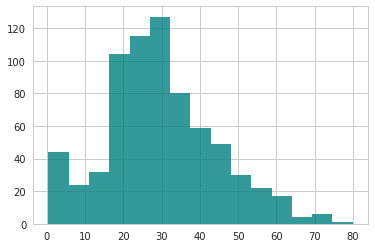

In [124]:
titanic_df["Age"].hist(bins=15, color='teal', alpha=0.8)

Since "Age" is (right) skewed, using the mean might give us biased results by filling in ages that are older than desired.  To deal with this, we'll use the median to impute the missing values. 

In [125]:
# median age is 28 (as compared to mean which is ~30)
titanic_df["Age"].median(skipna=True)

28.0

### 2.2 Cabin - Missing Values

In [126]:
# proportion of "cabin" missing
round(687/len(titanic_df["PassengerId"]),4)

0.771

77% of records are missing, which means that imputing information and using this variable for prediction is probably not wise.  We'll ignore this variable in our model.

### 2.3 Embarked - Missing Values

In [127]:
# proportion of "Embarked" missing
round(2/len(titanic_df["PassengerId"]),4)

0.0022

There are only 2 missing values for "Embarked", so we can just impute with the port where most people boarded.

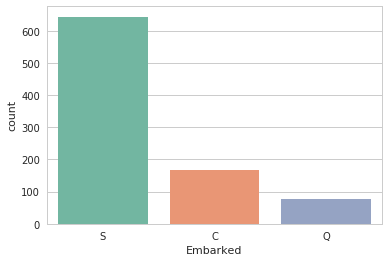

In [128]:
sns.countplot(x='Embarked',data=titanic_df,palette='Set2')
plt.show()

By far the most passengers boarded in Southhampton, so we'll impute those 2 NaN's w/ "S".

*References for graph creation:*<br>
https://matplotlib.org/1.2.1/examples/pylab_examples/histogram_demo.html <br>
https://seaborn.pydata.org/generated/seaborn.countplot.html

### 2.4 Final Adjustments to Data (Train & Test)

Based on my assessment of the missing values in the dataset, I'll make the following changes to the data:
* If "Age" is missing for a given row, I'll impute with 28 (median age).
* If "Embark" is missing for a riven row, I'll impute with "S" (the most common boarding port).
* I'll ignore "Cabin" as a variable.  There are too many missing values for imputation.  Based on the information available, it appears that this value is associated with the passenger's class and fare paid.

In [129]:
train_data = titanic_df
train_data["Age"].fillna(28, inplace=True)
train_data["Embarked"].fillna("S", inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

### 2.4.1 Additional Variables

According to the Kaggle data dictionary, both SibSp and Parch relate to traveling with family.  For simplicity's sake (and to account for possible multicollinearity), I'll combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

In [130]:
## Create categorical variable for traveling alone

train_data['TravelBuds']=train_data["SibSp"]+train_data["Parch"]
train_data['TravelAlone']=np.where(train_data['TravelBuds']>0, 0, 1)

In [131]:
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)
train_data.drop('TravelBuds', axis=1, inplace=True)

I'll also create categorical variables for Passenger Class ("Pclass"), Gender ("Sex"), and Port Embarked ("Embarked"). 

In [132]:
#create categorical variable for Pclass

train2 = pd.get_dummies(train_data, columns=["Pclass"])

In [133]:
train3 = pd.get_dummies(train2, columns=["Embarked"])

In [134]:
train4=pd.get_dummies(train3, columns=["Sex"])
train4.drop('Sex_female', axis=1, inplace=True)

In [135]:
train4.drop('PassengerId', axis=1, inplace=True)
train4.drop('Name', axis=1, inplace=True)
train4.drop('Ticket', axis=1, inplace=True)
train4.head(5)

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


In [136]:
df_final = train4

### Now, apply the same changes to the test data. <br>
I will apply to same imputation for "Age" in the Test data as I did for my Training data (if missing, Age = 28).  <br> I'll also remove the "Cabin" variable from the test data, as I've decided not to include it in my analysis. <br> There were no missing values in the "Embarked" port variable.  I'll add dummy variables to finalize the test set.

In [137]:
test_df["Age"].fillna(28, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [138]:
test_df['TravelBuds']=test_df["SibSp"]+test_df["Parch"]
test_df['TravelAlone']=np.where(test_df['TravelBuds']>0, 0, 1)

test_df.drop('SibSp', axis=1, inplace=True)
test_df.drop('Parch', axis=1, inplace=True)
test_df.drop('TravelBuds', axis=1, inplace=True)

test2 = pd.get_dummies(test_df, columns=["Pclass"])
test3 = pd.get_dummies(test2, columns=["Embarked"])

test4=pd.get_dummies(test3, columns=["Sex"])
test4.drop('Sex_female', axis=1, inplace=True)

test4.drop('PassengerId', axis=1, inplace=True)
test4.drop('Name', axis=1, inplace=True)
test4.drop('Ticket', axis=1, inplace=True)
final_test = test4

In [139]:
final_test.head(5)

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


*References for categorical variable creation: <br>
http://pbpython.com/categorical-encoding.html <br>
https://chrisalbon.com/python/data_wrangling/pandas_create_column_using_conditional/*

## 3. Exploratory Data Analysis

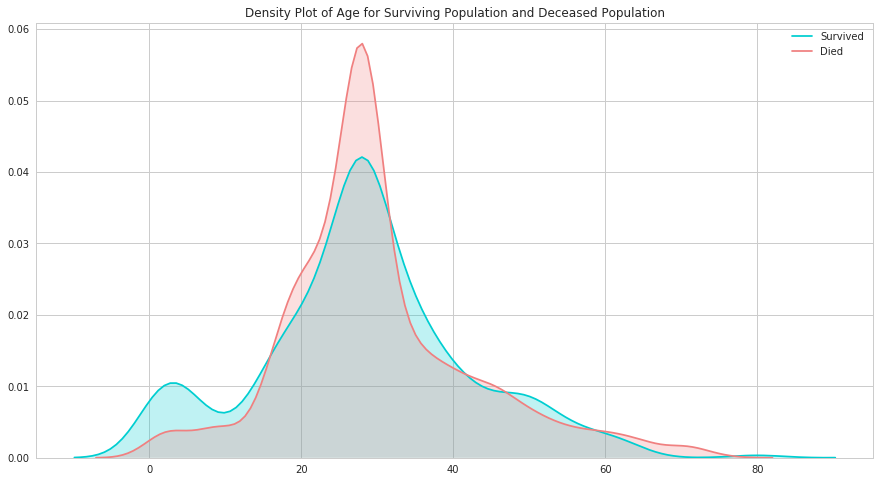

In [140]:
plt.figure(figsize=(15,8))
sns.kdeplot(titanic_df["Age"][df_final.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(titanic_df["Age"][df_final.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
plt.show()


The age distribution for survivors and deceased is actually very similar.  One notable difference is that, of the survivors, a larger proportion were children.  The passengers evidently made an attempt to save children by giving them a place on the life rafts. 

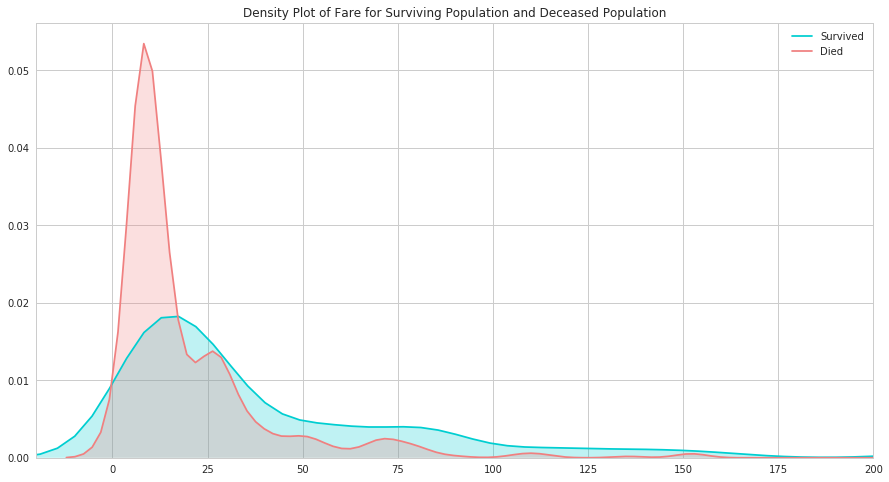

In [141]:
plt.figure(figsize=(15,8))
sns.kdeplot(df_final["Fare"][titanic_df.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(df_final["Fare"][titanic_df.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
# limit x axis to zoom on most information. there are a few outliers in fare. 
plt.xlim(-20,200)
plt.show()

As the distributions are clearly different for the fares of survivors vs. deceased, it's likely that this would be a significant predictor in our final model.  Passengers who paid lower fare appear to have been less likely to survive.  This is probably strongly correlated with Passenger Class, which we'll look at next.

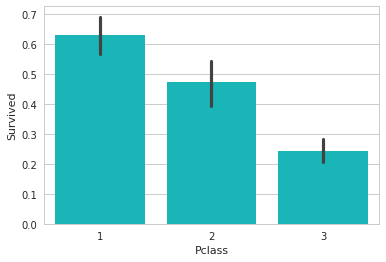

In [142]:
sns.barplot('Pclass', 'Survived', data=titanic_df, color="darkturquoise")
plt.show()

Unsurprisingly, being a first class passenger was safest.

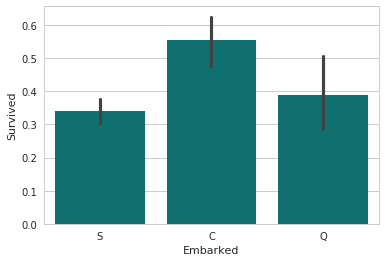

In [143]:
sns.barplot('Embarked', 'Survived', data=titanic_df, color="teal")
plt.show()

Passengers who boarded in Cherbourg, France, appear to have the highest survival rate.  Passengers who boarded in Southhampton were marginally less likely to survive than those who boarded in Queenstown.  This is probably related to passenger class, or maybe even the order of room assignments (e.g. maybe earlier passengers were more likely to have rooms closer to deck). <br> It's also worth noting the size of the whiskers in these plots.  Because the number of passengers who boarded at Southhampton was highest, the confidence around the survival rate is the highest.  The whisker of the Queenstown plot includes the Southhampton average, as well as the lower bound of its whisker.  It's possible that Queenstown passengers were equally, or even more, ill-fated than their Southhampton counterparts.

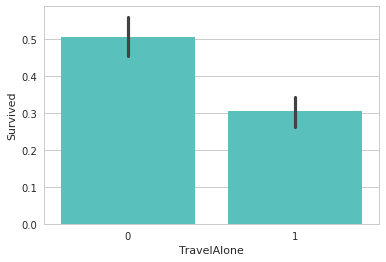

In [144]:
sns.barplot('TravelAlone', 'Survived', data=df_final, color="mediumturquoise")
plt.show()

Individuals traveling without family were more likely to die in the disaster than those with family aboard.  Given the era, it's likely that individuals traveling alone were likely male.

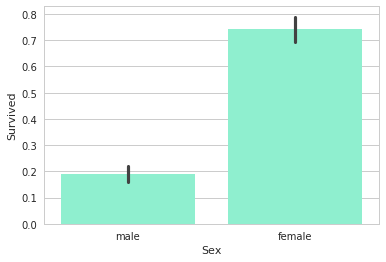

In [145]:
sns.barplot('Sex', 'Survived', data=titanic_df, color="aquamarine")
plt.show()

This is a very obvious difference.  Clearly being female greatly increased your chances of survival.

References: <br>
https://seaborn.pydata.org/generated/seaborn.barplot.html <br>
https://seaborn.pydata.org/generated/seaborn.kdeplot.html

## 4. Logistic Regression and Results

In [146]:
df_final.head(10)

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1
5,0,28.0,8.4583,1,0,0,1,0,1,0,1
6,0,54.0,51.8625,1,1,0,0,0,0,1,1
7,0,2.0,21.0750,0,0,0,1,0,0,1,1
8,1,27.0,11.1333,0,0,0,1,0,0,1,0
9,1,14.0,30.0708,0,0,1,0,1,0,0,0


In [147]:
cols=["Age", "Fare", "TravelAlone", "Pclass_1", "Pclass_2","Embarked_C","Embarked_S","Sex_male"] 
X=df_final[cols]
Y=df_final['Survived']

In [148]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.456972
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:                Tue, 09 Jan 2018   Pseudo R-squ.:                  0.3138
Time:                        20:38:38   Log-Likelihood:                -407.16
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 2.034e-76
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age            -0.0191      0.007     -2.929      0.003      -0.032      -0.006
Fare            0.0022    

Nearly all variables are significant at the 0.05 alpha level, but we'll run the model again without Fare and TravelAlone (removed one at a time, results didn't change much.  In the end removed both).

In [149]:
cols2=["Age", "Pclass_1", "Pclass_2","Embarked_C","Embarked_S","Sex_male"] 
X2=df_final[cols2]
Y=df_final['Survived']

logit_model=sm.Logit(Y,X2)
result=logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.458585
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Tue, 09 Jan 2018   Pseudo R-squ.:                  0.3113
Time:                        20:38:38   Log-Likelihood:                -408.60
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.131e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0158      0.006     -2.602      0.009      -0.028      -0.004
Pclass_1       2.0449      0.

In [150]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X2, Y)

logreg.score(X2, Y)

0.79349046015712688

## Model's Predictive Score: 0.7935

*References:* <br>
https://github.com/statsmodels/statsmodels/issues/3931 <br>
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

## 5. Hold-Out Testing

### 5.1 Using Kaggle's Titanic "Test" Data

In [151]:
#from sklearn.linear_model import LogisticRegression
#from sklearn import metrics
#logreg = LogisticRegression()
#logreg.fit(X2, Y)

#X_test = final_test[cols2]
#y_test = final_test['Survived']

#y_pred = logreg.predict(X_test)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


</div>
 <div class="alert alert-block alert-danger">
<font color=red> **Cross Validation: Turns out the test data doesn't have "survived" information, so this isn't helpful for our out-of-sample analysis.** </font>



### 5.2 Using 80-20 Split for Cross Validation

In [152]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_final, test_size=0.2)

*References:* <br>
https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas

In [153]:
#re-fit logistic regression on new train sample

cols2=["Age", "Pclass_1", "Pclass_2","Embarked_C","Embarked_S","Sex_male"] 
X3=train[cols2]
Y3=train['Survived']

logit_model3=sm.Logit(Y3,X3)
result3=logit_model3.fit()
print(result3.summary())

Optimization terminated successfully.
         Current function value: 0.464120
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      706
Method:                           MLE   Df Model:                            5
Date:                Tue, 09 Jan 2018   Pseudo R-squ.:                  0.3035
Time:                        20:38:38   Log-Likelihood:                -330.45
converged:                       True   LL-Null:                       -474.46
                                        LLR p-value:                 3.769e-60
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0152      0.007     -2.256      0.024      -0.028      -0.002
Pclass_1       1.9776      0.

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X3, Y3)
logreg.score(X3, Y3)

0.7935393258426966

The score of the logistic regression on our 80% sample training data is very close to our original, full-sample sized, model.  <br>
Let's assess how well it scores on the 20% hold-out sample.

In [155]:
from sklearn import metrics
logreg.fit(X3, Y3)

X3_test = test[cols2]
Y3_test = test['Survived']

Y3test_pred = logreg.predict(X3_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X3_test, Y3_test)))

Accuracy of logistic regression classifier on test set: 0.80


The model's out of sample performance does not show any deterioration.<br>
*Resources:* <br>
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html <br>
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

## Assessing the model's performance based on ROC/AUC 

In [156]:
# Model's in sample AUC

from sklearn.metrics import roc_auc_score
logreg.fit(X3, Y3)
Y3_pred = logreg.predict(X3)

y_true = Y3
y_scores = Y3_pred
roc_auc_score(y_true, y_scores)

0.77821384528213844

ROC AUC: 0.851


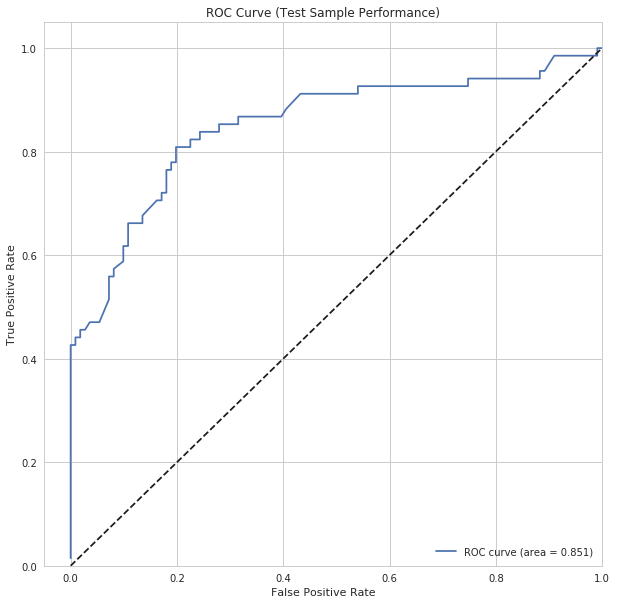

In [158]:
#Visualizing the model's ROC curve (**source for graph code given below the plot)
from sklearn.metrics import roc_curve, auc
logreg.fit(X3, Y3)

y_test = Y3_test
X_test = X3_test
 
# Determine the false positive and true positive rates
FPR, TPR, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
 
# Calculate the AUC

roc_auc = auc(FPR, TPR)
print ('ROC AUC: %0.3f' % roc_auc )
 
# Plot of a ROC curve
plt.figure(figsize=(10,10))
plt.plot(FPR, TPR, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Sample Performance)')
plt.legend(loc="lower right")
plt.show()

An AUC score of 0.5 is effectively as good as the flip of a coin, and means that the model really has no classification power at all between the positive and negative occurences. The AUC for both the test and train samples when run on my logistic regression demonstrates relatively strong power of separation between positive and negative occurences (survived - 1, died - 0).

> ### "AUC of a classifier is equivalent to the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance." -Majnik, Bosnic, 2011<br> 

<br> *References*: <br>
ROC Analysis of Classifiers in Machine Learning: A Survey, Matjaz Majnik, Zoran Bosnic, 2011: <br>
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.301.969&rep=rep1&type=pdf<br>

https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
http://www.ultravioletanalytics.com/2014/12/16/kaggle-titanic-competition-part-x-roc-curves-and-auc/

# Conclusion<br>
<br> 
Based on my analysis, if you were to be aboard the Titanic, your chances of survival were best if you fit the following criteria:<br>
* Female
* Young
* In First Class 
* Embarked in Cherbourg France


**Final References:** <br>
*Editing Markdowns*: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed<br>
*Matplotlib color library:* https://matplotlib.org/examples/color/named_colors.html